In [1]:
from tqdm import tnrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
%matplotlib inline  
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
BATCH_SIZE = 1000

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=4)

In [3]:
def onehotTensor(category,n_categories):
    tensor = torch.zeros(1, n_categories,dtype=torch.long)
    tensor[0][category] = 1
    return tensor
        
def get_accuracy(logit, target):
    batch_size = len(target)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+nhidden*(noutputs+1)

# a custom RNN
class PRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden,n_output,dt,device):
        super(PRNN, self).__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.dt = nn.Parameter(torch.Tensor([dt]))
        self.a = nn.Parameter(torch.Tensor([1]))
        self.sig = nn.Sigmoid()
        self.decoder = nn.Linear(n_hidden, n_output)
        self.encoder = nn.Linear(n_inputs, n_hidden)
        self.recurrent = nn.Linear(n_hidden,n_hidden)
        
    def forward(self, x0):
        x0=x0.permute(1,0,2)
        self.h1 = torch.zeros(1,BATCH_SIZE,self.n_hidden).to(device)
        for i in range(x0.size(0)):
#             self.h1 = (1-self.sig(self.dt))*self.h1+self.sig(self.dt)*torch.tanh(self.a*self.encoder(x0[i,:,:])+self.recurrent(self.h1))
            self.h1 = self.sig(self.dt)*torch.tanh(self.a*self.encoder(x0[i,:,:])) #+self.recurrent(self.h1))
        self.y1 = self.decoder(self.h1)
        
        return self.y1

In [4]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_HIDDEN = 112
N_OUTPUTS = 10
N_EPHOCS = 5
N_REPS = 2 # 15
N_PARAMS = nparam(N_INPUTS,N_HIDDEN,N_OUTPUTS)

lambdas = np.arange(0,5.5,0.5,dtype=np.float)
N_LAMBDA = len(lambdas)
gidx = int(N_HIDDEN/2)

In [5]:
# regularizing digonal blocks of the partitioned RNN
train_loss_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_loss_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_P = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_P = [None]*N_LAMBDA*N_REPS
regval_P = []
for r in tnrange(N_REPS):
    for k in tnrange(N_LAMBDA):
        reg_lambda = lambdas[k]
        # model_path = 'D:\chongguo\git\AM221pset\Project\Final Project\History\Lamb\model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_path = './models/amplify_input_nomem_P_model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_P[k+r*N_LAMBDA] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        l2_reg = torch.tensor(1,device=device)
        optimizer = torch.optim.SGD(model_P[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(N_EPHOCS):
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_P[k+r*N_LAMBDA].train()
            for p, param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_P[nps,epoch,k,r]=plist[j].item()
                        nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device)
                optimizer.zero_grad()
                y_pred = model_P[k+r*N_LAMBDA](x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                for p,param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN and param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=1)
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=1)
                        elif param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_P.append(l2_reg.item())
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
            
            running_test_acc=0
            running_test_loss=0
            model_P[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_P[k+r*N_LAMBDA](x_test.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_test_pred.view(BATCH_SIZE,N_OUTPUTS),y_test_tar)
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
                
            train_loss_P[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_P[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_P[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_P[epoch,k,r] = running_test_acc/len(testloader)
            
        # save the model and free the memory  
        torch.save(model_P[k+r*N_LAMBDA].state_dict(), model_path)
        model_P[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

In [6]:
# save random elements
pickle.dump([lambdas,N_EPHOCS,N_REPS,
             Phist_P,
             regval_P,
             test_acc_P, train_acc_P,
             test_loss_P, train_loss_P], 
            open( "amplify_input_no_mem_diagonal_elements_sess_params_0404.pkl", "wb" ) )


In [7]:
# regularizing random elements of the matrix
train_loss_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_loss_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_R = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_R =  [None] * N_LAMBDA*N_REPS
regval_R = []
for r in tnrange(N_REPS):
    # generate a random binary mask for the parameter
    rndmask = torch.FloatTensor(N_HIDDEN, N_HIDDEN).uniform_() > 0.5
    while not rndmask.float().norm(p=1)==int(N_HIDDEN**2/2):
        if rndmask.float().norm(p=1)>int(N_HIDDEN**2/2):
            while True:
                rndidx = np.random.randint(N_HIDDEN,size=(2))
                if rndmask[rndidx[0],rndidx[1]]==1:
                    rndmask[rndidx[0],rndidx[1]]=0
                    break
        else:
            while True:
                rndidx = np.random.randint(N_HIDDEN,size=(2))
                if rndmask[rndidx[0],rndidx[1]]==0:
                    rndmask[rndidx[0],rndidx[1]]=1
                    break
    rndmask = rndmask.to(device)
    for k in tnrange(N_LAMBDA):
        reg_lambda = lambdas[k]
#         model_path = '/Users/vinayakvsv/am221/AM221pset/Project/vv_sandbox/mlp_experiments/model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_path = './models/amplify_input_nomem_R_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_R[k+r*N_LAMBDA] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        l2_reg = torch.tensor(1,device=device)
        optimizer = torch.optim.SGD(model_R[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(N_EPHOCS):
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_R[k+r*N_LAMBDA].train()
            for p, param in enumerate(model_R[k+r*N_LAMBDA].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_R[nps,epoch,k,r]=plist[j].item()
                        nps+=1
                        
            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device)
                optimizer.zero_grad()
                y_pred = model_R[k+r*N_LAMBDA](x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                for p,param in enumerate(model_R[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN and param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + torch.masked_select(param,rndmask).norm(p=1)
                        elif param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_R.append(l2_reg.item())
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
              
            running_test_acc=0
            running_test_loss=0
            model_R[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_R[k+r*N_LAMBDA](x_test.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
              
            train_loss_R[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_R[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_R[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_R[epoch,k,r] = running_test_acc/len(testloader)
            
        # save the model and free the memory  
        torch.save(model_R[k+r*N_LAMBDA].state_dict(), model_path)
        model_R[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

In [8]:
# save random elements
pickle.dump([lambdas,N_EPHOCS,N_REPS,
             Phist_R,
             regval_R,
             test_acc_R, train_acc_R,
             test_loss_R, train_loss_R], 
            open( "amplify_input_no_mem_random_elements_sess_params_0404.pkl", "wb" ) )

# pickle.dump([lambdas,N_EPHOCS,N_REPS,
#              Phist_P,Phist_C,Phist_R,
#              regval_P,regval_C,regval_R,
#              test_acc_P, train_acc_P,
#              test_acc_C, train_acc_C,
#              test_acc_R, train_acc_R,
#              test_loss_P, train_loss_P,
#              test_loss_C, train_loss_C,
#              test_loss_R, train_loss_R], 
#             open( "sess_params_0404.pkl", "wb" ) )

In [9]:
# regularizing off-digonal blocks of the partitioned RNN
train_loss_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_loss_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_C = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_C =  [None] * N_LAMBDA*N_REPS
regval_C = []
for r in tnrange(N_REPS):
    for k in tnrange(N_LAMBDA):
        reg_lambda = lambdas[k]
#         model_path = 'D:\chongguo\git\AM221pset\Project\Final Project\History\Lamb\model_C_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_path = './models/amplify_input_nomem_C_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_C[k+r*N_LAMBDA] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        l2_reg = torch.tensor(1,device=device)
        optimizer = torch.optim.SGD(model_C[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(N_EPHOCS):
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_C[k+r*N_LAMBDA].train()
            for p, param in enumerate(model_C[k+r*N_LAMBDA].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_C[nps,epoch,k,r]=plist[j].item()
                        nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device)
                optimizer.zero_grad()
                y_pred = model_C[k+r*N_LAMBDA](x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                for p,param in enumerate(model_C[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN and param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,gidx:].norm(p=1)
                            l2_reg = l2_reg + param[gidx:,:gidx].norm(p=1)
                        elif param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_C.append(l2_reg.item())
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
              
            running_test_acc=0
            running_test_loss=0
            model_C[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_C[k+r*N_LAMBDA](x_test.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
              
            train_loss_C[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_C[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_C[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_C[epoch,k,r] = running_test_acc/len(testloader)
            
        # save the model and free the memory  
        torch.save(model_C[k+r*N_LAMBDA].state_dict(), model_path)
        model_C[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

In [10]:
pickle.dump([lambdas,N_EPHOCS,N_REPS,
             Phist_C,
             regval_C,
             test_acc_C, train_acc_C,
             test_loss_C, train_loss_C], 
            open( "amplify_input_no_mem_off_diag_sess_params_0404.pkl", "wb" ) )

In [11]:

# pickle.dump([lambdas,N_EPHOCS,N_REPS,Phist_P,Phist_C,Phist_R,regval_P,regval_C,regval_R,test_acc_P, train_acc_P,test_acc_C, train_acc_C,test_acc_R, train_acc_R,test_loss_P, train_loss_P,test_loss_C, train_loss_C,test_loss_R, train_loss_R], open( "sess_params_0404.pkl", "wb" ) )

pickle.dump([lambdas,N_EPHOCS,N_REPS,
             Phist_P,Phist_C,Phist_R,
             regval_P,regval_C,regval_R,
             test_acc_P, train_acc_P,
             test_acc_C, train_acc_C,
             test_acc_R, train_acc_R,
             test_loss_P, train_loss_P,
             test_loss_C, train_loss_C,
             test_loss_R, train_loss_R], 
            open( "amplify_input_no_mem_sess_params_0404.pkl", "wb" ) )

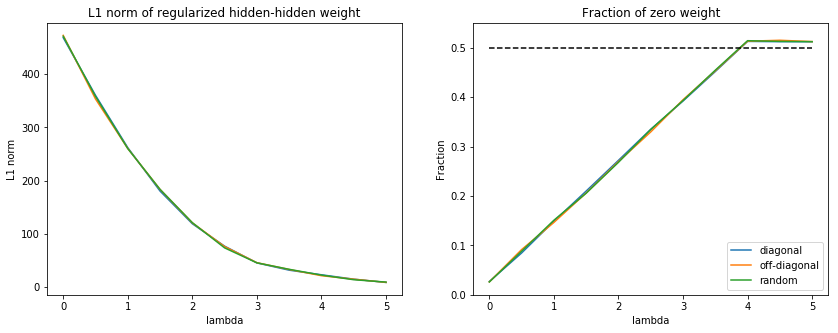

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sidx = int((N_INPUTS+N_OUTPUTS+1)*N_HIDDEN)
ridx = int(N_HIDDEN*N_HIDDEN)
rval_P = np.asarray(regval_P)
rval_P = np.mean(rval_P.reshape(N_REPS,int(len(rval_P)/N_REPS)).T,axis=1)
rval_P = rval_P.reshape(N_LAMBDA,int(len(rval_P)/N_LAMBDA)).T
rval_C = np.asarray(regval_C)
rval_C = np.mean(rval_C.reshape(N_REPS,int(len(rval_C)/N_REPS)).T,axis=1)
rval_C = rval_C.reshape(N_LAMBDA,int(len(rval_C)/N_LAMBDA)).T
rval_R = np.asarray(regval_R)
rval_R = np.mean(rval_R.reshape(N_REPS,int(len(rval_R)/N_REPS)).T,axis=1)
rval_R = rval_R.reshape(N_LAMBDA,int(len(rval_R)/N_LAMBDA)).T
plt.plot(lambdas,rval_P[-1,],label='diagonal')
plt.plot(lambdas,rval_C[-1,],label='off-diagonal')
plt.plot(lambdas,rval_R[-1,],label='random')
plt.title('L1 norm of regularized hidden-hidden weight')
plt.ylabel('L1 norm')
plt.xlabel('lambda')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_P[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='diagonal')
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_C[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='off-diagonal')
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_R[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='random')
plt.plot(lambdas,0.5*np.ones_like(lambdas),'k--')
plt.ylim((0,.55))
plt.legend()
plt.title('Fraction of zero weight')
plt.xlabel('lambda')
plt.ylabel('Fraction')
plt.show()

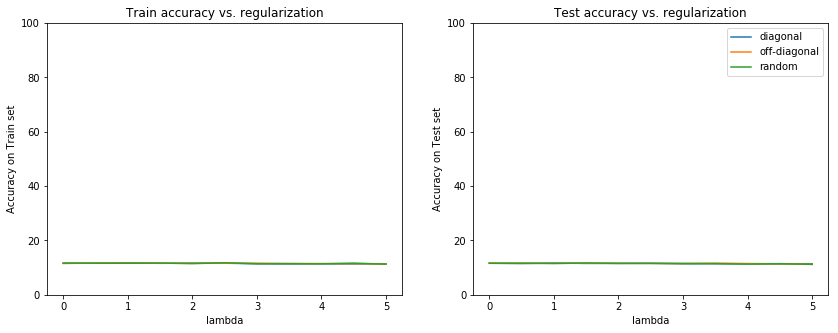

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lambdas,np.mean(train_acc_P[-1,:,:].squeeze(),axis = 1).T,'-')
plt.plot(lambdas,np.mean(train_acc_C[-1,:,:].squeeze(),axis = 1).T,'-')
plt.plot(lambdas,np.mean(train_acc_R[-1,:,:].squeeze(),axis = 1).T,'-')
plt.ylim((0,100))
plt.title('Train accuracy vs. regularization')
plt.xlabel('lambda')
plt.ylabel('Accuracy on Train set')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(test_acc_P[-1,:,:].squeeze(),axis = 1).T,'-',label='diagonal')
plt.plot(lambdas,np.mean(test_acc_C[-1,:,:].squeeze(),axis = 1).T,'-',label='off-diagonal')
plt.plot(lambdas,np.mean(test_acc_R[-1,:,:].squeeze(),axis = 1).T,'-',label='random')
plt.legend()
plt.ylim((0,100))
plt.title('Test accuracy vs. regularization')
plt.xlabel('lambda')
plt.ylabel('Accuracy on Test set')
plt.show()

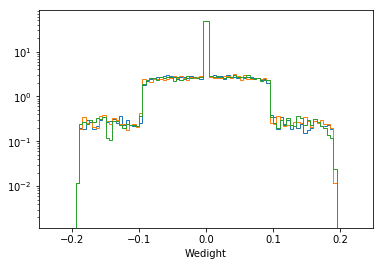

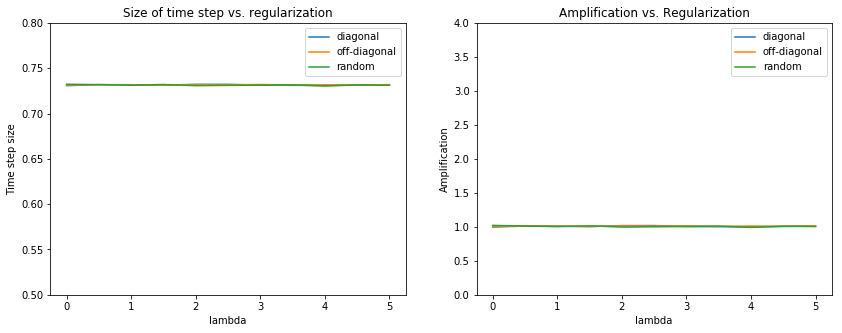

In [16]:
plt.hist(Phist_P[:,-1,-1,0],label='diagonal',normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.hist(Phist_C[:,-1,-1,0],label='off-diagonal',normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.hist(Phist_R[:,-1,-1,0],label='random',normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.xlim((-.25,.25))
plt.xlabel('Wedight')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_P[0,-1,:,:],axis=1).squeeze())),'-',label='diagonal')
plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_C[0,-1,:,:],axis=1).squeeze())),'-',label='off-diagonal')
plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_R[0,-1,:,:],axis=1).squeeze())),'-',label='random')
plt.ylim((0.5,0.8))
plt.legend()
plt.title('Size of time step vs. regularization')
plt.ylabel('Time step size')
plt.xlabel('lambda')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(Phist_P[1,-1,:,:],axis=1).squeeze(),'-',label='diagonal')
plt.plot(lambdas,np.mean(Phist_C[1,-1,:,:],axis=1).squeeze(),'-',label='off-diagonal')
plt.plot(lambdas,np.mean(Phist_R[1,-1,:,:],axis=1).squeeze(),'-',label='random')
plt.ylim((0,4))
plt.legend()
plt.title('Amplification vs. Regularization')
plt.ylabel('Amplification')
plt.xlabel('lambda')
plt.show()